In [1]:
import numpy as np
import tensorflow as tf
import sys

import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline

2022-04-14 08:56:37.561776: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /pbs/throng/lsst/users/bbiswas/miniconda3/envs/debvader/lib/:
2022-04-14 08:56:37.561821: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
sys.path.insert(0,'../')
from scripts.FlowVAEnet import FlowVAEnet
from scripts.utils import listdir_fullpath

## Load images

In [3]:
bands = [4,5,6,7,8,9]

######## List of data samples
def listdir_fullpath(d):
    return [os.path.join(d, f) for f in os.listdir(d) if not f.endswith("metadata.npy")]

datalist = listdir_fullpath("/sps/lsst/users/bbiswas/simulations/COSMOS_btk/")

train_path = datalist[:800]
validation_path = datalist[800:]

# Take 1000 images from the first file.
images = np.load(validation_path[0], allow_pickle=True)

## Convernt image to linear normalization
Note that the images were non-linearly normalized before being saved. So do denormalization first.

In [4]:
from debvader.normalize import LinearNormCosmos

In [5]:
isolated_images = images['isolated_gal_stamps']

Text(0.5, 1.0, 'difference')

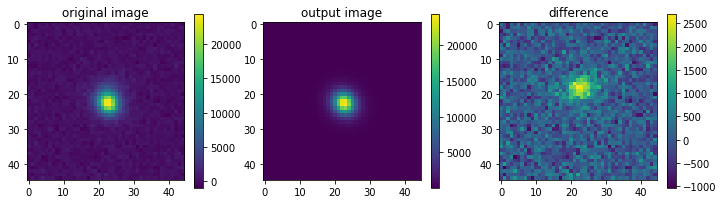

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(12,4))

image_num = 5

im = axs[0].imshow(images['blended_gal_stamps'][image_num][2, :, :])
fig.colorbar(im, ax=axs[0], shrink=0.8)
axs[0].set_title("original image")

im = axs[1].imshow(images['isolated_gal_stamps'][image_num][2, :, :])
fig.colorbar(im, ax=axs[1], shrink=0.8)
axs[1].set_title("output image")


difference = images['blended_gal_stamps'][image_num][2, :, :] - images['isolated_gal_stamps'][image_num][2, :, :]
im = axs[2].imshow(difference)
fig.colorbar(im, ax=axs[2],shrink=0.8)
axs[2].set_title("difference")

In [7]:
images_isolated_normed = LinearNormCosmos().forward(np.array(np.array(images['isolated_gal_stamps'].tolist())))
images_isolated_normed = np.transpose(images_isolated_normed, axes=(0, 2, 3, 1))

images_blended_normed = LinearNormCosmos().forward(np.array(np.array(images['blended_gal_stamps'].tolist())))
images_blended_normed = np.transpose(images_blended_normed, axes=(0, 2, 3, 1))

## Load trained models

In [8]:
tf.get_logger().setLevel('ERROR')

flow_net = FlowVAEnet(latent_dim=10)
#flow_net.load_flow_weights(weights_path="/pbs/throng/lsst/users/bbiswas/FlowDeblender/data/cosmos10d_largesig/flow/val_loss")
flow_net.load_vae_weights(weights_path="/pbs/throng/lsst/users/bbiswas/FlowDeblender/data/cosmos10d_largesig_largekl/vae/val_loss")
print(flow_net.vae_model.summary())

2022-04-14 08:56:49.497812: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /pbs/throng/lsst/users/bbiswas/miniconda3/envs/debvader/lib/:
2022-04-14 08:56:49.497864: W tensorflow/stream_executor/cuda/cuda_driver.cc:312] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-14 08:56:49.497900: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jns-bbiswas.cc.in2p3.fr): /proc/driver/nvidia/version does not exist
2022-04-14 08:56:49.498199: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-14 0

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 45, 45, 6)]       0         
_________________________________________________________________
encoder (Functional)         (None, 65)                6869397   
_________________________________________________________________
multivariate_normal_tri_l (M ((None, 10), (None, 10))  0         
_________________________________________________________________
decoder (Functional)         (None, 45, 45, 6)         3988684   
Total params: 10,858,081
Trainable params: 10,858,069
Non-trainable params: 12
_________________________________________________________________
None


# Section 1: Test the VAE

### Section 1.1 reconstructions.
If the VAE is able to correctly reconstruct images, we can conclude that the decoder can be used as a generative model

In [9]:
tf.get_logger().setLevel('ERROR')
model_vae_output_isolated = flow_net.vae_model(images_isolated_normed)

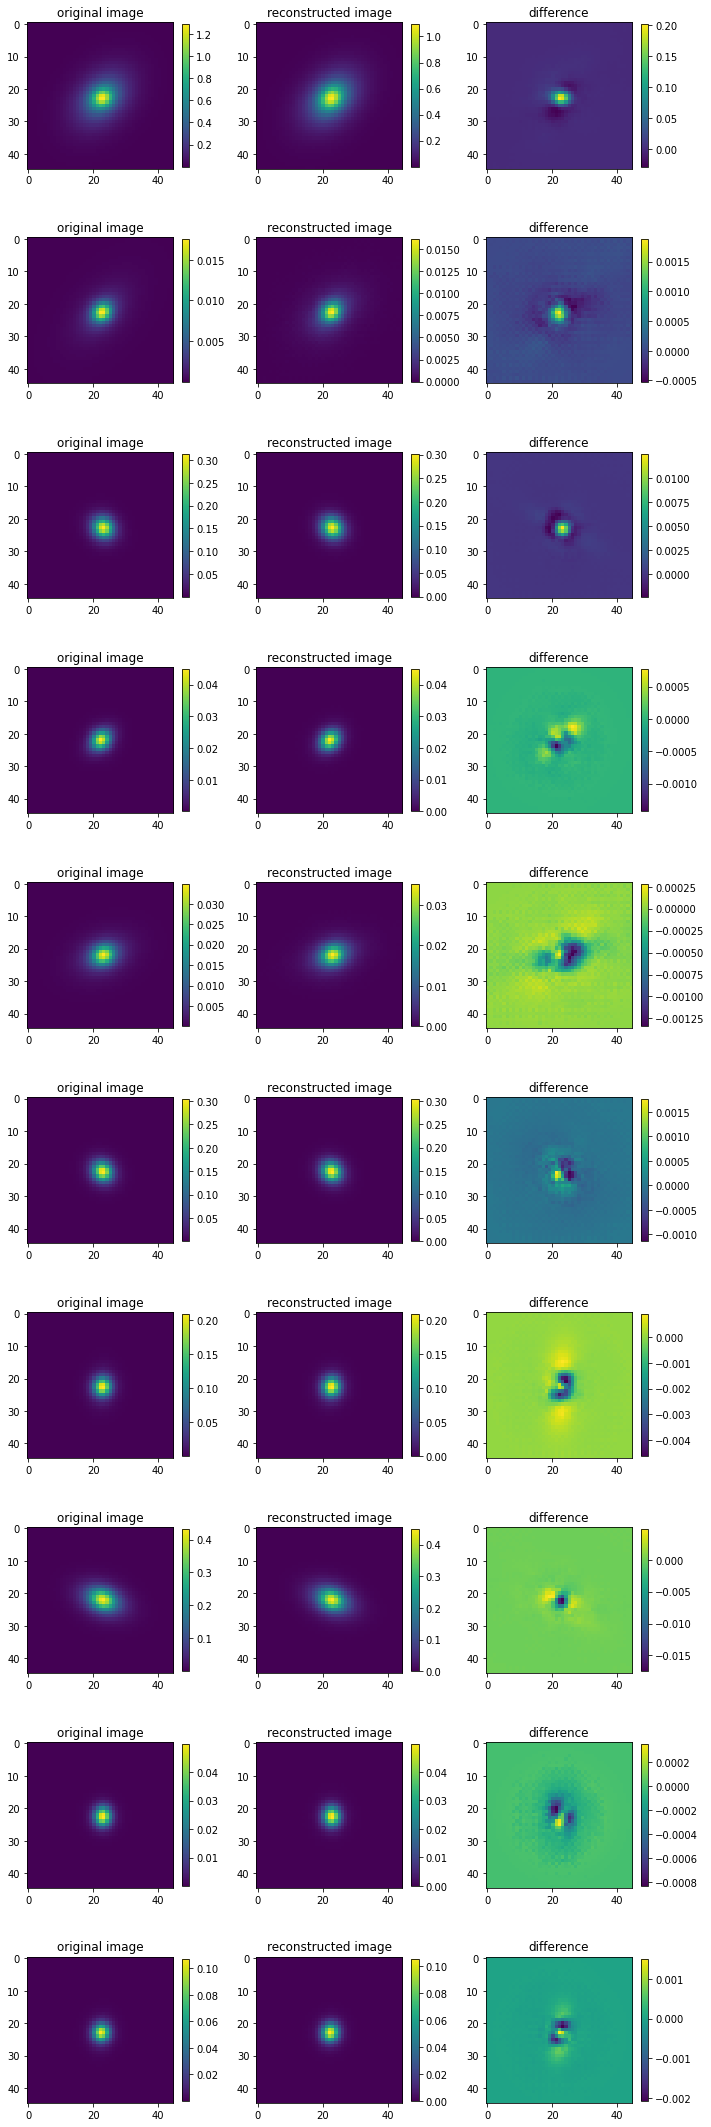

In [10]:
fig, axs = plt.subplots(10, 3, figsize=(10,30))


for i in range(10):
    
    image_num = i
    im = axs[i, 0].imshow(images_isolated_normed[image_num][:, :, 2])
    fig.colorbar(im, ax=axs[i, 0], shrink=0.8)
    axs[i, 0].set_title("original image")

    im = axs[i, 1].imshow(model_vae_output_isolated.mean().numpy()[image_num][ :, :, 2])
    fig.colorbar(im, ax=axs[i, 1], shrink=0.8)
    axs[i, 1].set_title("reconstructed image")


    difference = images_isolated_normed[image_num][:, :, 2] - model_vae_output_isolated.mean().numpy()[image_num][ :, :, 2]
    im = axs[i, 2].imshow(difference)
    fig.colorbar(im, ax=axs[i, 2],shrink=0.8)
    axs[i, 2].set_title("difference")

plt.tight_layout()

In [11]:
import tensorflow_probability as tfp
z = tfp.layers.MultivariateNormalTriL(event_size=10)(flow_net.encoder(images_isolated_normed))

Conclusion: The reconstructions of galaxies work fairly well! <br>
So the decoder can be used as a generative model by sampling from the latent space.

### Section 1.2 Latent space distribution

In this section we aim to study the latent space distribution of galaxies as learnt by the VAE

In [12]:
images = np.load(validation_path[0], allow_pickle=True)

In [13]:
latent_vars = []
for i in range(30):
    images_i = np.load(validation_path[i], allow_pickle=True)
    images_isolated_normed = LinearNormCosmos().forward(np.array(np.array(images_i['isolated_gal_stamps'].tolist())))
    images_isolated_normed = np.transpose(images_isolated_normed, axes=(0, 2, 3, 1))
    
    z = tfp.layers.MultivariateNormalTriL(event_size=10)(flow_net.encoder(images_isolated_normed))
    for j in range(20):
        latent_vars.extend(list(z.sample().numpy()))
latent_vars = np.array(latent_vars)

KeyboardInterrupt: 

In [ ]:
latent_vars_list =[]
for i in range(10):
    latent_vars_list.append(latent_vars[:, i])

Text(0, 0.5, 'distribution')

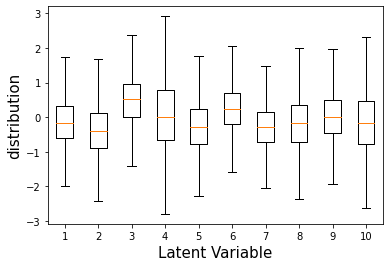

In [14]:
plt.boxplot(latent_vars_list, showfliers=False);
plt.xlabel("Latent Variable", fontsize=15)
plt.ylabel("distribution", fontsize=15)

The plot shows the distribution of the latent space variables as learnt by the VAE. <br>
In the next section we will try to see if we can model this distribution using the Normalizing Flow network. 

# Section 2. Test the flow network

### Section 2.1 Likelihood distribution

In [ ]:
images = np.load(validation_path[0], allow_pickle=True)

images_isolated_normed = LinearNormCosmos().forward(np.array(np.array(images['isolated_gal_stamps'].tolist())))
images_isolated_normed = np.transpose(images_isolated_normed, axes=(0, 2, 3, 1))

images_blended_normed = LinearNormCosmos().forward(np.array(np.array(images['blended_gal_stamps'].tolist())))
images_blended_normed = np.transpose(images_blended_normed, axes=(0, 2, 3, 1))

In [ ]:
isolated_likelihood = flow_net.flow_model(images_isolated_normed)
noisy_likelihood = flow_net.flow_model(images_blended_normed)

likelihood_difference=isolated_likelihood-noisy_likelihood

In [ ]:
fig = plt.figure(figsize=(5,5))
plt.scatter(isolated_likelihood, noisy_likelihood)
max_lim = max(np.amax(isolated_likelihood), np.amax(noisy_likelihood))
min_lim = min(np.amin(isolated_likelihood), np.amin(noisy_likelihood))
plt.xlim(-1000, max_lim+10)
plt.ylim(-1000, max_lim+10)
plt.plot((min_lim, max_lim), (min_lim, max_lim), ls="--", c="r", label="equal likelihood")
ax = plt.gca()
ax.set_aspect('equal')
plt.xlabel("Likelihood of isolated galaxies", fontsize=12)
plt.ylabel("Likelihood of noisy / blended galaxies", fontsize=12)
plt.legend()

In [ ]:
plt.hist(likelihood_difference.numpy(), bins=30);

### Section 2.2 Learnt latent space distribution

Finally, let's try to see the distribution of latent variables learnt by the normalizing flow:

In [ ]:
sampled_latent_vars = flow_net.td.sample(10000).numpy()
sampled_latent_vars_list =[]
for i in range(10):
    sampled_latent_vars_list.append(sampled_latent_vars[:, i])

In [ ]:
plt.boxplot(sampled_latent_vars_list, showfliers=False);
plt.xlabel("sampled latent Variable", fontsize=15)
plt.ylabel("distribution", fontsize=15)

On comparing the sampled latent space distribution with the actual distribution, we see by eye that the flow nework is able to learn the complex distribution in the latent space.